# Time Series Analysis

*Analysis conducted by Gauthier Schweitzer, for the X/HEC x eleven hackathon*

## Importing the quotes

### Importing libraries

In [175]:
import pandas as pd
from selenium import webdriver
import time
import re
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
from bs4 import BeautifulSoup
from html_table_extractor.extractor import Extractor
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import norm

### Setting up the browser

In [ ]:
# Setup Chrome
driver = webdriver.Chrome('/Users/Gauthier/Documents/CoursENSAE/3A/MOOC/Applied_marchine_learning_in_python/chromedriver') #replace with .Firefox(), or with the browser of your choice

# Go to the website
driver.get('https://coinmarketcap.com/currencies/bitcoin/historical-data/?start=20130428&end=20180911')

# It is important to wait to let the page load. However, better to use more precise functions such as Web Driver Wait
time.sleep(2)

# We extract the HTML
innerHTML = driver.execute_script("return document.body.innerHTML")

# We quit the browser
driver.quit()

### Setting up and launching the parser

In [37]:
# We parse the data using BeautifulSoup
soup = BeautifulSoup(innerHTML, 'lxml')
table_doc = soup

# We extract the table
extractor = Extractor(table_doc)
extractor.parse()
table=extractor.return_list()

# We convert it to df
table[0:][:]
quote = pd.DataFrame(table[1:][:], columns=table[0])
quote.head()

,Date,Open*,High,Low,Close**,Volume,Market Cap
0,"Sep 10, 2018","6 301,57","6 374,98","6 292,76","6 329,70",3 714 100 000,108 759 350 260
1,"Sep 09, 2018","6 223,38","6 446,26","6 201,22","6 300,86",3 671 890 000,107 397 286 192
2,"Sep 08, 2018","6 460,17","6 534,25","6 197,52","6 225,98",3 835 060 000,111 471 362 532
3,"Sep 07, 2018","6 528,92","6 555,29","6 396,87","6 467,07",4 264 680 000,112 645 200 318
4,"Sep 06, 2018","6 755,14","6 755,14","6 404,72","6 529,17",5 523 470 000,116 535 447 253


### Changing format

In [38]:
for column in ['Open*', 'High', 'Low', 'Close**', 'Volume', 'Market Cap']:
    for i in range(len(quote[column])):
        quote.loc[i,column] = str(quote.loc[i,column]).replace('\xa0', '')
        quote.loc[i,column] = str(quote.loc[i,column]).replace(',', '.')
        quote.loc[i,column] = str(quote.loc[i,column]).replace('-', '')
        
quote['Date'] = pd.to_datetime(quote['Date'])
for column in ['Open*', 'High', 'Low', 'Close**', 'Volume', 'Market Cap']:
    quote[column] = pd.to_numeric (quote[column])

We sort values by descending date and describe the dataframe

In [90]:
quote.sort_values('Date', ascending = True, inplace = True)
quote.reset_index(inplace=True, drop=True)
quote.describe()

,Open*,High,Low,Close**,Volume,Market Cap,price
count,1962.000000,1962.000000,1962.000000,1962.000000,1.719000e+03,1.962000e+03,1962.000000
mean,2128.006381,2196.859256,2051.129878,2130.940234,1.515017e+09,3.501951e+10,2128.006381
std,3413.154898,3544.515794,3253.128690,3413.887889,3.195428e+09,5.795958e+10,3413.154898
min,68.500000,74.560000,65.530000,68.430000,2.857830e+06,7.792550e+08,68.500000
25%,296.560000,311.810000,290.985000,298.462500,2.520725e+07,4.211945e+09,296.560000
50%,583.445000,590.675000,573.300000,584.265000,6.819840e+07,7.763335e+09,583.445000
75%,1592.557500,1697.020000,1587.630000,1691.690000,1.207830e+09,2.598450e+10,1592.557500
max,19475.800000,20089.000000,18974.100000,19497.400000,2.384090e+10,3.261413e+11,19475.800000


In [228]:
quote.to_csv("btc_quote.csv")

In [229]:
!ls

README.md                        ghostdriver.log
Time series.ipynb                scraping_selenium-linkedin.ipynb
add.txt                          scraping_selenium.ipynb
btc_quote.csv


## Analysis

For each day, we consider that the price is the Open price of the day. We thus build a small database with the date as the index.

In [92]:
df = quote[['Date','Open*']].rename(columns={"Date":"date","Open*":"price"}).set_index('date',drop=False)

### Stylized facts

In this subsection, we will see that the series obtained have some special properties, that they share with most of the financial series (mainly stocks).

#### Price

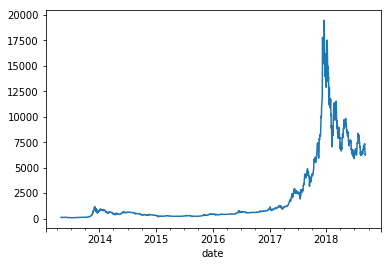

In [120]:
df['price'].plot()
plt.show()

#### Yield

We add a lag and compute the yield

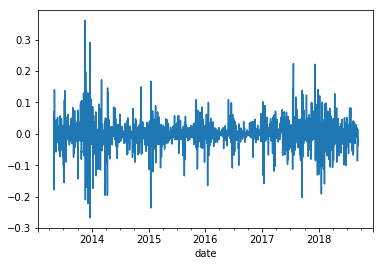

In [121]:
df['price_lag1']=df['price'].shift(1)
df.dropna(inplace=True)
df['yield']=np.log(df['price']/df['price_lag1'])
df['yield'].plot()
plt.show()

We observe **much movement around 0, with very different ranges, but with a mean module that is constant in the long range**.

#### Empirical autocorrelation

Autocorrelation and partial autocorrelation plots are heavily used in time series analysis and forecasting.
These are plots that graphically summarize the strength of a relationship with an observation in a time series with observations at prior time steps. 

We can calculate the correlation for time series observations with observations with previous time steps, called lags. Because the correlation of the time series observations is calculated with values of the same series at previous times, this is called a serial correlation, or an autocorrelation.

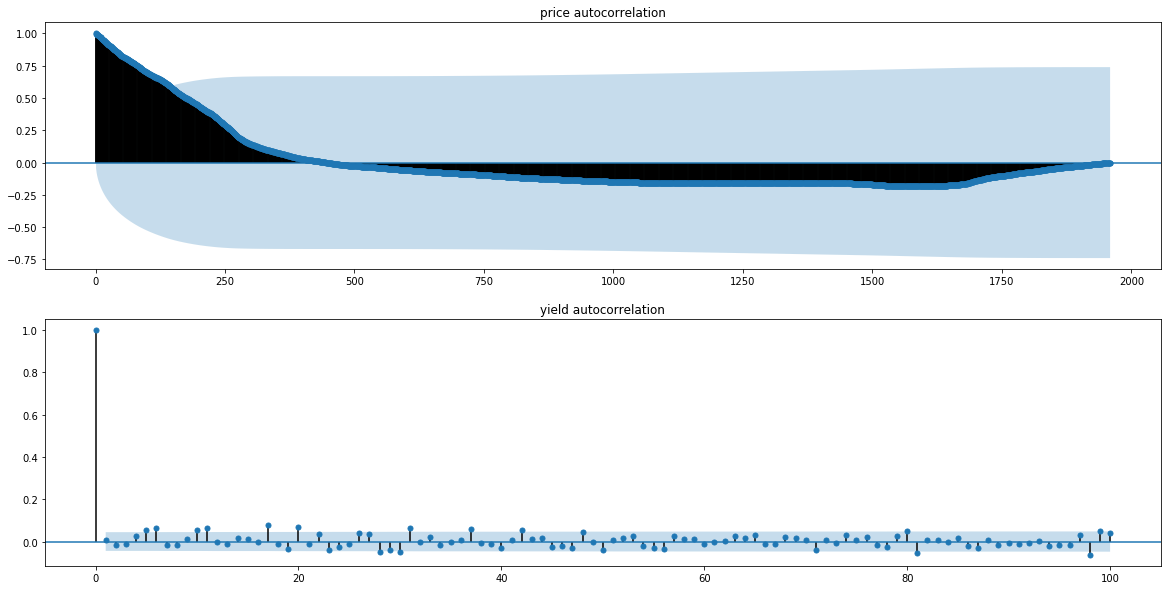

In [159]:
fig, axes = plt.subplots(2,1, figsize=(20, 10))
plot_acf(df['price'], ax=axes[0])
plot_acf(df['yield'], lags=100, ax=axes[1])
axes[0].set_title("price autocorrelation")
axes[1].set_title("yield autocorrelation")
plt.show()

As expected, price autocorrelation is **huge** when you directly consider the price series. Looking at yiled autocorrelation, it "more or less" lies within the 95% confidence interval, indicating that **autocorrelation is statistically nul. The series is very close to a white noise. **

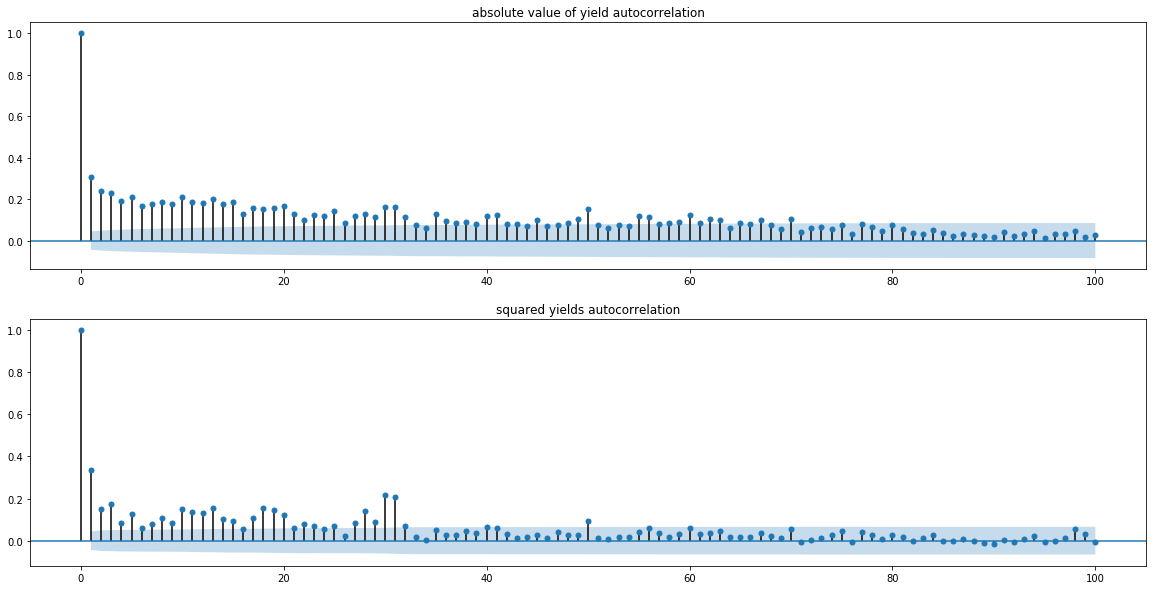

In [168]:
fig, axes = plt.subplots(2,1, figsize=(20, 10))
plot_acf(np.abs(df['yield']), lags=100, ax=axes[0])
plot_acf(df['yield']**2, lags=100, ax=axes[1])
axes[0].set_title("absolute value of yield autocorrelation")
axes[1].set_title("squared yield autocorrelation")
plt.show()

As observed in the two previous graphs, there exists non-linear correlation (no strong with noise). Strong absolute values of the yield tend to be followed by strong absolute values of the yield, same with small ones.  That is what is called "volatility clustering". However, **homoskedasticity might not be violated. What is probably violated is conditional homoskedasticity: the conditional variance of the yield, given previous values of the yield is not constant.**

#### Normality

/Users/Gauthier/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


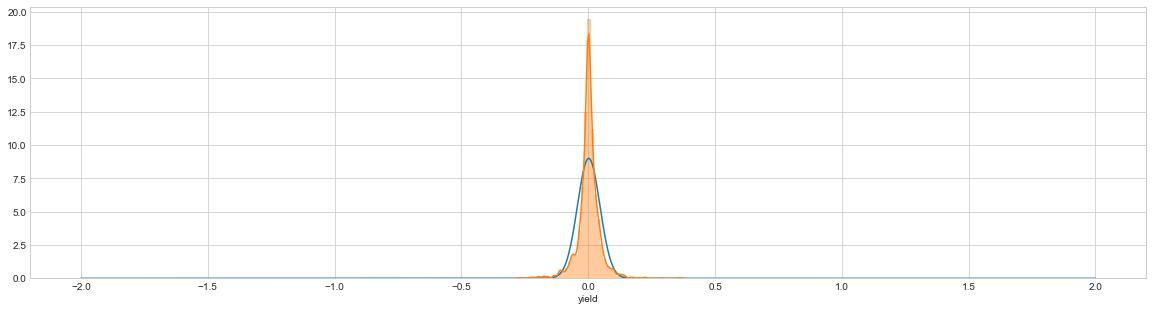

In [226]:
plt.figure(figsize=(20,5))
x = np.linspace(-2,2,1000)
y = norm.pdf(x, loc=np.mean(df['yield']), scale=np.sqrt(np.var(df['yield'])))
plt.plot(x,y)

sns.set_style('whitegrid')
sns.distplot(df['yield'], norm_hist=True)

plt.show()

When fitting a normal distribution (blue) on the density of the yield (orange), it appears that the series of the yields have a bigger peak in 0 and fatter tails (kurtosis $\geq3$).